<a href="https://colab.research.google.com/github/Anarchist1984/SeminarProject/blob/main/t2_dataset_filtration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
! pip install rdkit --quiet

In [8]:
from pathlib import Path
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools

**Time to calculate and Plot Molecular Properties using RDKit**

In [9]:
ro5_properties = {
    "molecular_weight": (500, "molecular weight (Da)"),
    "n_hba": (10, "# HBA"),
    "n_hbd": (5, "# HBD"),
    "logp": (5, "logP"),
}

**Now we are interested in calculating what molecules violate Ro5**

In [10]:
def calculate_ro5_properties(smiles):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    pandas.Series
        Molecular weight, number of hydrogen bond acceptors/donor and logP value
        and Lipinski's rule of five compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    ro5_fulfilled = sum(conditions) >= 3
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "ro5_fulfilled"],
    )

According to the Ro5, cyclosporin and betacarotene are estimated to have poor bioavailability. However, since all of them are approved drugs, they are good examples of how the Ro5 can be used as an alert but should not necessarily be used as a filter very strictly.

In [11]:
#@title Choose Your file
#@markdown Run this only if you are using a file prepared in t1 that is saved in your google drive otherwise specify a path that is in the local context.
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/Mathew_AP_Seminar/Research Project/Data/MMP9-Inhibitor_Compounds.csv' #@param {type:'string'}

Mounted at /content/drive


##Come to the Real Business
Now we are going to upload our dataset, which was prepared in Part-1 for actuall calculations.

In [12]:
molecules = pd.read_csv(folder_path, index_col=0)
print(molecules.shape)
molecules.head()

(2034, 5)


,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL323090,0.01,nM,COc1ccc(S(=O)(=O)N(CC(=O)NCC2CCCCC2)C(CCSCc2cc...,11.000000
1,CHEMBL2064547,0.03,nM,COc1ccc(S(=O)(=O)N(Cc2cn(CCF)nn2)[C@@H](C(=O)N...,10.522879
2,CHEMBL2064549,0.05,nM,COc1ccc(S(=O)(=O)N(Cc2cn(CCOCCOCCOCCF)nn2)[C@@...,10.301030
3,CHEMBL2064548,0.06,nM,COc1ccc(S(=O)(=O)N(Cc2cn(CCOCCOCCOCCOS(=O)(=O)...,10.221849
4,CHEMBL2425947,0.07,nM,COc1ccc(S(=O)(=O)N(CCn2cc(CCCF)nn2)[C@@H](C(=O...,10.154902


Perform **Ro5** calculations on all compounds

In [13]:
# This takes a couple of seconds
ro5_properties = molecules["smiles"].apply(calculate_ro5_properties)
ro5_properties.head()

,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,563.212378,7,3,3.57990,True
1,429.148218,8,2,0.97710,True
2,561.226862,11,2,1.02690,False
3,713.240049,14,2,1.77132,False
4,457.179518,8,2,1.40970,True


Concatenate molecules with Ro5 data calculations

In [14]:
molecules = pd.concat([molecules, ro5_properties], axis=1)
molecules.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL323090,0.01,nM,COc1ccc(S(=O)(=O)N(CC(=O)NCC2CCCCC2)C(CCSCc2cc...,11.000000,563.212378,7,3,3.57990,True
1,CHEMBL2064547,0.03,nM,COc1ccc(S(=O)(=O)N(Cc2cn(CCF)nn2)[C@@H](C(=O)N...,10.522879,429.148218,8,2,0.97710,True
2,CHEMBL2064549,0.05,nM,COc1ccc(S(=O)(=O)N(Cc2cn(CCOCCOCCOCCF)nn2)[C@@...,10.301030,561.226862,11,2,1.02690,False
3,CHEMBL2064548,0.06,nM,COc1ccc(S(=O)(=O)N(Cc2cn(CCOCCOCCOCCOS(=O)(=O)...,10.221849,713.240049,14,2,1.77132,False
4,CHEMBL2425947,0.07,nM,COc1ccc(S(=O)(=O)N(CCn2cc(CCCF)nn2)[C@@H](C(=O...,10.154902,457.179518,8,2,1.40970,True


In [15]:
# Note that the column "ro5_fulfilled" contains boolean values.
# Thus, we can use the column values directly to subset data.
# Note that ~ negates boolean values.
molecules_ro5_fulfilled = molecules[molecules["ro5_fulfilled"]]
molecules_ro5_violated = molecules[~molecules["ro5_fulfilled"]]

print(f"# compounds in unfiltered data set: {molecules.shape[0]}")
print(f"# compounds in filtered data set: {molecules_ro5_fulfilled.shape[0]}")
print(f"# compounds not compliant with the Ro5: {molecules_ro5_violated.shape[0]}")
# NBVAL_CHECK_OUTPUT

# compounds in unfiltered data set: 2034
# compounds in filtered data set: 1855
# compounds not compliant with the Ro5: 179


Why not save them

In [16]:
#This script will save the unfiltered data
folder_path = '/content/drive/MyDrive/Mathew_AP_Seminar/Research Project/Data'
molecules.to_csv(f'{folder_path}/ro5_properties.csv', index=True)

In [17]:
#This will Save filtered data
molecules_ro5_fulfilled.to_csv(f'{folder_path}/ro5_properties_filtered.csv', index=True)
molecules_ro5_fulfilled.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL323090,0.010,nM,COc1ccc(S(=O)(=O)N(CC(=O)NCC2CCCCC2)C(CCSCc2cc...,11.000000,563.212378,7,3,3.57990,True
1,CHEMBL2064547,0.030,nM,COc1ccc(S(=O)(=O)N(Cc2cn(CCF)nn2)[C@@H](C(=O)N...,10.522879,429.148218,8,2,0.97710,True
4,CHEMBL2425947,0.070,nM,COc1ccc(S(=O)(=O)N(CCn2cc(CCCF)nn2)[C@@H](C(=O...,10.154902,457.179518,8,2,1.40970,True
5,CHEMBL2425941,0.070,nM,CC(C)[C@H](C(=O)NO)N(CC#N)S(=O)(=O)c1ccc(OCCF)cc1,10.154902,373.110770,6,2,1.07918,True
6,CHEMBL75164,0.092,nM,O=CN(O)C(CS(=O)(=O)c1ccc(Oc2ccc(OC(F)(F)F)cc2)...,10.036212,465.070522,8,3,1.72060,True


##Lets calculate/Visualize Ro5 Analysis on Radar Plot for the Data

In [18]:
def calculate_mean_std(dataframe):
    """
    Calculate the mean and standard deviation of a dataset.

    Parameters
    ----------
    dataframe : pd.DataFrame
        Properties (columns) for a set of items (rows).

    Returns
    -------
    pd.DataFrame
        Mean and standard deviation (columns) for different properties (rows).
    """
    # Generate descriptive statistics for property columns
    stats = dataframe.describe()
    # Transpose DataFrame (statistical measures = columns)
    stats = stats.T
    # Select mean and standard deviation
    stats = stats[["mean", "std"]]
    return stats

Some statistics for the filtered dataset calculated above

In [19]:
molecules_ro5_fulfilled_stats = calculate_mean_std(
    molecules_ro5_fulfilled[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_fulfilled_stats
# NBVAL_CHECK_OUTPUT

,mean,std
molecular_weight,427.439051,91.927332
n_hba,5.545013,1.732983
n_hbd,2.353100,0.998845
logp,2.676010,1.338910


Molecules that violates the Ro5

In [20]:
molecules_ro5_violated_stats = calculate_mean_std(
    molecules_ro5_violated[["molecular_weight", "n_hba", "n_hbd", "logp"]]
)
molecules_ro5_violated_stats
# NBVAL_CHECK_OUTPUT

,mean,std
molecular_weight,713.393374,201.778861
n_hba,9.078212,4.223333
n_hbd,3.921788,3.069335
logp,4.865204,2.539009


Define helper functions to prepare data for radar plotting¶
In the following, we will define a few helper functions that are only used for radar plotting.

**Prepare y values:** The properties used for the Ro5 criteria are of different magnitudes. The MWT has a threshold of 500, whereas the number of HBAs and HBDs and the LogP have thresholds of only 10, 5, and 5, respectively. In order to visualize these different scales most simplistically, we will scale all property values to a scaled threshold of 5:

scaled property value = property value / property threshold * scaled property threshold

scaled MWT = MWT / 500 * 5 = MWT / 100

scaled HBA = HBA / 10 * 5 = HBA / 2

scaled HBD = HBD / 5 * 5 = HBD

scaled LogP = LogP / 5 * 5 = LogP

This results in a downscaling of the MWT by 100, HBA by 2, while HBD and LogP stay unchanged.

The following helper function performs such a scaling and will be used later during radar plotting.

In [21]:
def _scale_by_thresholds(stats, thresholds, scaled_threshold):
    """
    Scale values for different properties that have each an individually defined threshold.

    Parameters
    ----------
    stats : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.

    Returns
    -------
    pd.DataFrame
        DataFrame with scaled means and standard deviations for each physiochemical property.
    """
    # Raise error if scaling keys and data_stats indicies are not matching
    for property_name in stats.index:
        if property_name not in thresholds.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
    # Scale property data
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)
    return stats_scaled

**Prepare x values:** The following helper function returns the angles of the physicochemical property axes for the radar chart. For example, if we want to generate a radar plot for 4 properties, we want to set the axes at 0°, 90°, 180°, and 270°. The helper function returns such angles as radians.

In [22]:
def _define_radial_axes_angles(n_axes):
    """Define angles (radians) for radial (x-)axes depending on the number of axes."""
    x_angles = [i / float(n_axes) * 2 * math.pi for i in range(n_axes)]
    x_angles += x_angles[:1]
    return x_angles

Now generate Radar Plot

In [23]:
def plot_radar(
    y,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max=None,
    output_path=None,
):
    """
    Plot a radar chart based on the mean and standard deviation of a data set's properties.

    Parameters
    ----------
    y : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.
    properties_labels : list of str
        List of property names to be used as labels in the plot.
    y_max : None or int or float
        Set maximum y value. If None, let matplotlib decide.
    output_path : None or pathlib.Path
        If not None, save plot to file.
    """

    # Define radial x-axes angles -- uses our helper function!
    x = _define_radial_axes_angles(len(y))
    # Scale y-axis values with respect to a defined threshold -- uses our helper function!
    y = _scale_by_thresholds(y, thresholds, scaled_threshold)
    # Since our chart will be circular we append the first value of each property to the end
    y = pd.concat([y, y.head(1)])

    # Set figure and subplot axis
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # Plot data
    ax.fill(x, [scaled_threshold] * len(x), "cornflowerblue", alpha=0.2)
    ax.plot(x, y["mean"], "b", lw=3, ls="-")
    ax.plot(x, y["mean"] + y["std"], "orange", lw=2, ls="--")
    ax.plot(x, y["mean"] - y["std"], "orange", lw=2, ls="-.")

    # From here on, we only do plot cosmetics
    # Set 0° to 12 o'clock
    ax.set_theta_offset(math.pi / 2)
    # Set clockwise rotation
    ax.set_theta_direction(-1)

    # Set y-labels next to 180° radius axis
    ax.set_rlabel_position(180)
    # Set number of radial axes' ticks and remove labels
    plt.xticks(x, [])
    # Get maximal y-ticks value
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    # Set axes limits
    plt.ylim(0, y_max)
    # Set number and labels of y axis ticks
    plt.yticks(
        range(1, y_max),
        ["5" if i == scaled_threshold else "" for i in range(1, y_max)],
        fontsize=16,
    )

    # Draw ytick labels to make sure they fit properly
    # Note that we use [:1] to exclude the last element which equals the first element (not needed here)
    for i, (angle, label) in enumerate(zip(x[:-1], properties_labels)):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
        ax.text(
            x=angle,
            y=y_max + 1,
            s=label,
            size=16,
            horizontalalignment=ha,
            verticalalignment="center",
        )

    # Add legend relative to top-left plot
    labels = ("mean", "mean + std", "mean - std", "rule of five area")
    ax.legend(labels, loc=(1.1, 0.7), labelspacing=0.3, fontsize=16)

    # Save plot - use bbox_inches to include text boxes
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    plt.show()

Now here we will generate two Radar plots. One for the filtered data (which satisfy the Ro5) and vice versa.

In [24]:
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# HBA / 2",
    "# HBD",
    "LogP",
]
y_max = 8

**1. Radar Plot for Filtered Dataset**

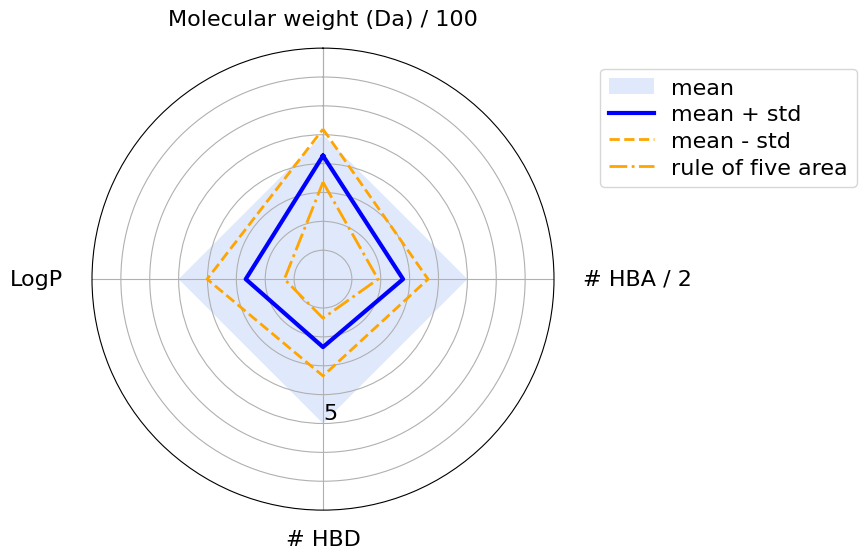

In [25]:
plot_radar(
    molecules_ro5_fulfilled_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

Radar plot for the molecules that violated the Ro5

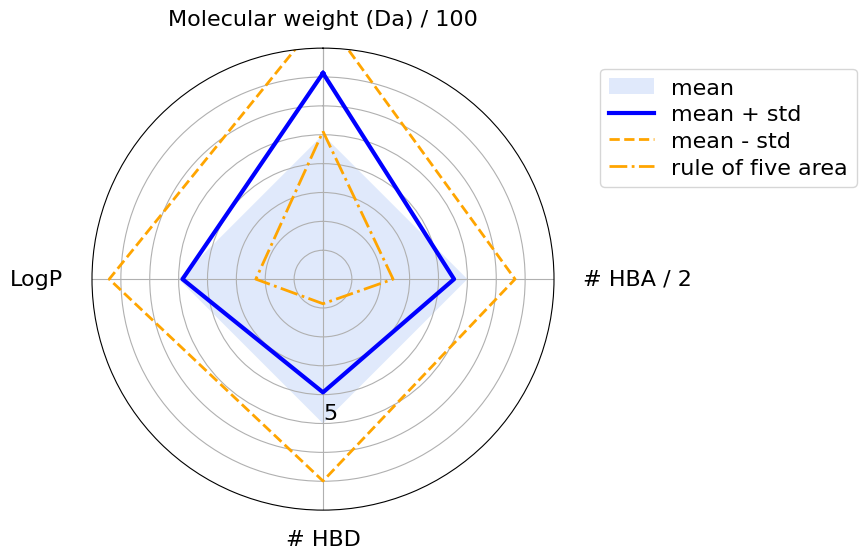

In [26]:
plot_radar(
    molecules_ro5_violated_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)


The blue square shows the area where a molecule’s physicochemical properties are compliant with the Ro5. The blue line highlights the mean values, while the orange dashed lines show the standard deviations. We can see that the mean values never violate any of Lipinski’s rules. However, according to the standard deviation, some properties have larger values then the Ro5 thresholds. This is acceptable because, according to the Ro5, one of the four rules can be violated.

**In the case of violated compunds we can see that logP and MW violated**